# Denoising Autoencodeur

## Intuition

### Denoising, qu'est ce que c'est ? 

La tâche de denoising consiste à enlever le bruit indésirable d'une image. C'est une tâche très importante dans le domaine du traitement d'images.   
Pour nous, l'idée serait d'avoir en entrée du réseau une image bruitée et en sortie une image nette.   

<img src="images/Denoising.jpg" alt="denoising" width="600"/>  

Figure extraite de [article](https://www.researchgate.net/publication/350432472_A_Modified_Heat_Diffusion_Based_Method_for_Enhancing_Physical_Images).

### Utilisation d'un autoencodeur pour la tâche de denoising

Pour utiliser l'architecture de l'autoencodeur pour ce problème, il suffit de donner en entrée du décodeur une image bruitée (par nos soins), lui faire reconstruire l'image et comparer l'image reconstruite à l'image non bruitée.  

<img src="images/DenoisedLena.png" alt="denoising" width="800"/>  

En utilisant ce type d'architecture on cherche à créer un modèle de débruitage robuste qui sera capable de débruiter toutes les images. Bien entendu, pour son entraînement, il faudra une grosse base d'image et il faut aussi veiller à ce que le bruit généré soit du même "type" que le bruit que l'on peut rencontrer sur des images réelles.

## Denoising autoencodeur en Pytorch

Encore une fois, nous allons utiliser le dataset MNIST. On va générer du bruit artificiel sur les images et entraîner notre autoencodeur à enlever ce bruit pour nous produire une image nette. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Dataset et dataloader

In [2]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Géneration de bruit

Faisons un exemple d'application de bruit pour visualiser la dégradation de l'image en fonction du niveau de bruit.

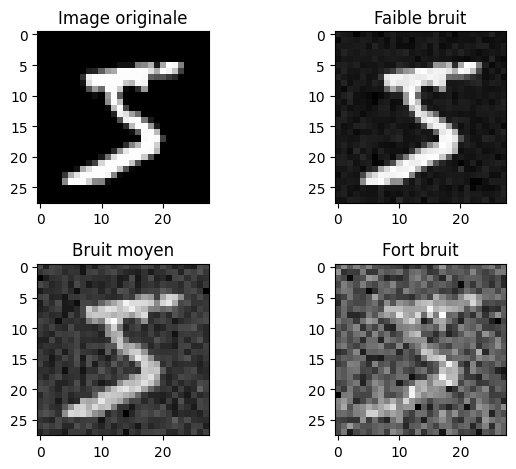

In [3]:
image,_=dataset[0]
# Le paramètre dans le np.sqrt correspond à la variance désirée donc np.sqrt(...) est l'écart type
# torch.randn génére des valeurs aléatoire extraites d'une distribution gaussienne de mean 0 et variance 1
imageNoisy1 = image + np.sqrt(0.001)*torch.randn(1, 28, 28)
imageNoisy2 = image + np.sqrt(0.01)*torch.randn(1, 28, 28)
imageNoisy3 = image + np.sqrt(0.1)*torch.randn(1, 28, 28)

plt.subplot(2, 2, 1)
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title("Image originale")

plt.subplot(2, 2, 2)
plt.imshow(imageNoisy1.squeeze().numpy(), cmap='gray')
plt.title("Faible bruit")

plt.subplot(2, 2, 3)
plt.imshow(imageNoisy2.squeeze().numpy(), cmap='gray')
plt.title("Bruit moyen")

plt.subplot(2, 2, 4)
plt.imshow(imageNoisy3.squeeze().numpy(), cmap='gray')
plt.title("Fort bruit")

plt.tight_layout()
plt.show()

Nous allons utiliser le niveau de bruit moyen lors de l'entraînement, on pourra ensuite voir comme notre denoising autoencodeur se comporte sur d'autres niveaux de bruit. 

### Création de notre modèle

Pour cette tâche complexe, nous allons utiliser un autoencodeur convolutif.

In [4]:
# Nous réutilisons les fonctions introduites dans l'exemple de segmentation du cours 3 
def conv_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
def convT_relu_bn(input_channels, output_channels, kernel_size, stride, padding):
  return nn.Sequential(
    nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
    nn.ReLU(),
    nn.BatchNorm2d(output_channels,momentum=0.01)
  )
    
    
class ae_conv(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.encoder = nn.Sequential( # Sequential permet de groupe une série de transformation
      conv_relu_bn(1,8,kernel_size=3,stride=2,padding=1),
      conv_relu_bn(8,16,kernel_size=3,stride=2,padding=1),
      conv_relu_bn(16,32,kernel_size=3,stride=1,padding=1),
    )
    self.decoder = nn.Sequential(
      convT_relu_bn(32,16,kernel_size=4,stride=2,padding=1),
      convT_relu_bn(16,8,kernel_size=4,stride=2,padding=1),
      nn.Conv2d(8,1,kernel_size=3,stride=1,padding=1),
      nn.Sigmoid()
    )
  
  def forward(self,x): 
    x = self.encoder(x)
    denoise = self.decoder(x)
    return denoise

In [5]:
model = ae_conv() # Couches d'entrée de taille 2, deux couches cachées de 16 neurones et un neurone de sortie
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

Nombre de paramètres 16385


### Entraînement du modèle

In [6]:
criterion = nn.MSELoss()
epochs=10
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
for i in range(epochs):
  loss_train=0
  for images, _ in train_loader:
    images=images+np.sqrt(0.01)*torch.randn(images.shape)
    recons=model(images)
    loss=criterion(recons,images)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, _ in val_loader:
    with torch.no_grad():
      images=images+np.sqrt(0.01)*torch.randn(images.shape)
      recons=model(images)
      loss=criterion(recons,images)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.0253756046295166
step 0 val loss 0.010878251865506172
step 1 train loss 0.00976449716836214
step 1 val loss 0.008979358710348606
step 2 train loss 0.00827114749699831
step 2 val loss 0.007526080124080181
step 3 train loss 0.00706455297768116
step 3 val loss 0.0066648973152041435
step 4 train loss 0.006312613375484943
step 4 val loss 0.005955129396170378
step 5 train loss 0.00576859712600708
step 5 val loss 0.005603262223303318
step 6 train loss 0.0055686105042696
step 6 val loss 0.005487256217747927
step 7 train loss 0.0054872902110219
step 7 val loss 0.005444051697850227
step 8 train loss 0.0054359594359993935
step 8 val loss 0.005416598636657
step 9 train loss 0.005397486500442028
step 9 val loss 0.005359680857509375


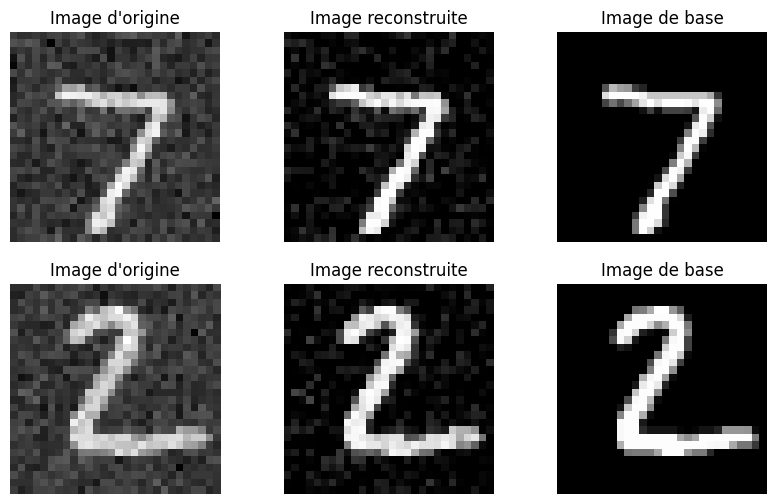

In [8]:
images,_=next(iter(test_loader))
variance=0.01
#Isolons un élément
fig, axs = plt.subplots(2, 3, figsize=(10, 6)) 
for i in range(2):
  image=images[i].unsqueeze(0)
  noisy_image=image+np.sqrt(variance)*torch.randn(image.shape)

  with torch.no_grad():
      recons=model(noisy_image)

  # Image d'origine
  axs[i][0].imshow(noisy_image[0].squeeze().cpu().numpy(), cmap='gray')
  axs[i][0].set_title('Image d\'origine')
  axs[i][0].axis('off')

  # Image reconstruite
  axs[i][1].imshow(recons[0].squeeze().cpu().numpy(), cmap='gray')
  axs[i][1].set_title('Image reconstruite')
  axs[i][1].axis('off')

  axs[i][2].imshow(image[0].squeeze().cpu().numpy(), cmap='gray')
  axs[i][2].set_title('Image de base')
  axs[i][2].axis('off')
plt.show()

Les résultats de notre denoising sont assez corrects bien qu'il reste encore quelques artefacts. En faisant varier le paramètre variance, vous pouvez visualiser ce que le denoising autoencodeur est capable de faire sur d'autres niveaux de bruit. 

## Exercice

Vous pouvez essayer d'entraîner le modèle sur des images avec un niveau de bruit aléatoire (compris entre certaines valeurs de variance) et voir si le modèle est capable de généraliser sur n'importe quel type de bruit gaussien compris dans l'intervalle.  Vous pourrez avoir besoin de complexifier le modèle et d'ajouter des *epochs* lors de l'entraînement. 

**U-Net** : Vous pouvez également essayer de tester l'achitecture U-Net (voir cours 3 sur la segmentation) pour la tâche de denoising et comparer les résultats avec l'autoencodeur.